# 基于注意力机制的时间序列预测

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
# 两种绘图接口
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 注意力机制

**Attention用于加强模型对重要信息的关注。**

注意力机制的内在规则：将大量注意力分配给少量真正重要的内容。这可以抽象成：给真正重要的信息分配较大的权重，再让信息参与运算，从而得到更有意义的运算结果。

注意力机制在编码—解码模型中的应用是通过引入注意力网络来实现的。注意力网络本身并不复杂，只是一个简单的前馈神经网络，而且一般使用一个隐藏层就足够了，但是它的加入可以训练数据的驱动，为模型提供注意力功能。

引入注意力网络的目的，是在解码过程中为解码器提供关注不同时刻编码器输入信息的能力。具体而言，在中译英任务中，当解码器生成下一个英语单词的时候，我们希望解码器不但能接收当前生成的英语单词作为输入（用于生成序列），还能接收一个表示“在当前状态下，更应该关注编码器的哪个部分”的信息。

注意力网络的输出是一组正实数，加起来等于1。它们是加到编码器各时间步隐含状态上的权重。

在生成权重信息后，我们可以将其与对应的编码器隐含状态做内积（先逐个相乘，再加到一起得到一个向量），这个过程即是对不同中文词语进行加权的过程。加权后再与当前解码器生成的英文单词一同输入解码器。由于此时解码器接收的信息不但包括了当前英文单词，也包括了当前应该关注的中文词语信息，所以解码器可以更准确地生成下一个英文单词。

![hello](../images/p27.jpg)

实际上，在使用PyTorch实现注意力网络的时候，我们的确将整个模型的计算图设计得更为复杂，但是整个计算图依然是相互连接、没有断点的。因此，只需要使用PyTorch的反向传播函数，依然可以对整个模型进行反馈调整。这就是PyTorch动态计算图的强大之处：无论多么复杂的网络模型，只要能生成连贯的计算图，都可以进行自动的反馈调整。现在许多前沿的神经网络研究基于动态计算图的机制，通过改变神经网络的结构来提升运算效果。

除了加入注意力网络之外，还有多种方式去改进编码—解码模型。GRU是LSTM的一种简单变体，可以将它应用到编码—解码模型中。

具体来说，在Seq2Seq模型中：

- 编码器（Encoder）的隐藏状态（encoder_hidden）： 当编码器处理输入序列时，它会生成一个隐藏状态，该隐藏状态包含了输入序列中信息的抽象表示。这个隐藏状态通常用于初始化解码器的隐藏状态。

- 解码器（Decoder）的隐藏状态（decoder_hidden）： 解码器接收编码器的隐藏状态作为初始隐藏状态，并且在解码的过程中动态地更新这个隐藏状态。这个隐藏状态用于生成目标序列。

## Bi-LSTM-Attention-Encoder-Decoder

### 模型定义

In [3]:
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        # LSTM层将输入序列映射到隐藏状态空间
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)

    def forward(self, x):
        # 将输入序列传入LSTM层，返回隐藏状态
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
        decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

        # 沿着最后一个维度拼接，比如(1,2)和(1,2)拼成之后就是(1,4)
        cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
        energy = torch.tanh(self.attn(cat_outputs))
        attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
        
        # 计算上下文向量
        context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
        return context, attention_weights

# 修改解码器模型，加入注意力机制
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim, num_layers):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(out_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        # 注意力机制作用完后的结果映射到后面的层
        self.out = nn.Linear(hidden_dim * (2+1), out_dim)  # 双向为2，注意力层为1
        self.attention = Attention(hidden_dim)

    def forward(self, y, hidden, cell, encoder_outputs):
        output, (hidden, cell) = self.lstm(y.view(len(y), 1, -1), (hidden, cell))
        # 使用注意力机制获取上下文向量和注意力权重
        context, attention_weights = self.attention(hidden[-1], encoder_outputs)
        # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
        cat_outputs = torch.cat((output.view(len(y), -1), context), dim=1)
        output = self.out(cat_outputs)
        return output, hidden, cell, attention_weights

# BiLAED模型
class BiLAED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, e_layers, d_layers):
        super(BiLAED, self).__init__()
        self.pred_len = pred_len
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        encoder_hidden, encoder_cell = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
        decoder_outputs = []
        for i in range(x_dec.size(1)):  # 遍历序列的每个时间步
            decoder_input = x_dec[:, i, :]
            decoder_output, decoder_hidden, _, _ = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
        dec_out = torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

## Bi-GRU-Attention-Encoder-Decoder

### 模型定义

In [4]:
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()
        # GRU层将输入序列映射到隐藏状态空间
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)

    def forward(self, x):
        # 将输入序列传入GRU层，返回隐藏状态
        _, hidden = self.gru(x)
        return hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim*2, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
        decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

        # 沿着最后一个维度拼接
        cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
        energy = torch.tanh(self.attn(cat_outputs))
        attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
        
        # 计算上下文向量
        context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
        return context, attention_weights

# 修改解码器模型，加入注意力机制
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim, num_layers):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(out_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        self.out = nn.Linear(hidden_dim * (2+1), out_dim)  
        self.attention = Attention(hidden_dim)

    def forward(self, y, hidden, encoder_outputs):
        output, hidden = self.gru(y.view(len(y), 1, -1), hidden)
        # 使用注意力机制获取上下文向量和注意力权重
        context, attention_weights = self.attention(hidden[-1], encoder_outputs)
        # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
        output = self.out(torch.cat((output.view(len(y), -1), context), dim=1))
        return output, hidden, attention_weights

# BiGAED模型
class BiGAED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, e_layers, d_layers):
        super(BiGAED, self).__init__()
        self.pred_len = pred_len
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        encoder_hidden = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        for i in range(x_dec.size(1)):  # 遍历序列的每个时间步
            decoder_input = x_dec[:, i, :]
            decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
        dec_out = torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

## LSTM-Attention-Encoder-Decoder

### 模型定义

In [5]:
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        # LSTM层将输入序列映射到隐藏状态空间
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = False)

    def forward(self, x):
        # 将输入序列传入LSTM层，返回隐藏状态
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim*2, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
        decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

        # 沿着最后一个维度拼接，比如(1,2)和(1,2)拼成之后就是(1,4)
        cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
        energy = torch.tanh(self.attn(cat_outputs))
        attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
        
        # 计算上下文向量
        context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
        return context, attention_weights

# 修改解码器模型，加入注意力机制
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(out_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = False)
        self.out = nn.Linear(hidden_dim * 2, out_dim)  # 注意：输出维度扩展为 hidden_dim * 2
        self.attention = Attention(hidden_dim)

    def forward(self, y, hidden, cell, encoder_outputs):
        output, (hidden, cell) = self.lstm(y.view(len(y), 1, -1), (hidden, cell))
        # 使用注意力机制获取上下文向量和注意力权重
        context, attention_weights = self.attention(hidden[-1], encoder_outputs)
        # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
        output = self.out(torch.cat((output.view(len(y), -1), context), dim=1))
        return output, hidden, cell, attention_weights

# LAED模型
class LAED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, e_layers, d_layers):
        super(LAED, self).__init__()
        self.pred_len = pred_len
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        encoder_hidden, encoder_cell = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell
        decoder_outputs = []
        for i in range(x_dec.size(1)):  # 遍历序列的每个时间步
            decoder_input = x_dec[:, i, :]
            decoder_output, decoder_hidden, _, _ = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
        dec_out = torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

## GRU-Attention-Encoder-Decoder

### 模型定义

In [6]:
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        # GRU层将输入序列映射到隐藏状态空间
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = False)

    def forward(self, x):
        # 将输入序列传入GRU层，返回隐藏状态
        _, hidden = self.gru(x)
        return hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim*2, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # 确保 decoder_hidden 的大小与 encoder_outputs 匹配
        decoder_hidden = decoder_hidden.repeat(encoder_outputs.size(0), 1, 1)

        # 沿着最后一个维度拼接
        cat_outputs = torch.cat((decoder_hidden, encoder_outputs), dim=-1)
        energy = torch.tanh(self.attn(cat_outputs))
        attention_weights = nn.functional.softmax(energy.squeeze(2), dim=0)
        
        # 计算上下文向量
        context = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=0)
        return context, attention_weights

# 修改解码器模型，加入注意力机制
class Decoder(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(out_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional = False)
        self.out = nn.Linear(hidden_dim * 2, out_dim)  # 注意：输出维度扩展为 hidden_dim * 2
        self.attention = Attention(hidden_dim)

    def forward(self, y, hidden, encoder_outputs):
        output, hidden = self.gru(y.view(len(y), 1, -1), hidden)
        # 使用注意力机制获取上下文向量和注意力权重
        context, attention_weights = self.attention(hidden[-1], encoder_outputs)
        # 将解码器输出和上下文向量横向拼接，并通过线性层映射到输出维度
        output = self.out(torch.cat((output.view(len(y), -1), context), dim=1))
        return output, hidden, attention_weights

# GAED模型
class GAED(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, e_layers, d_layers):
        super(GAED, self).__init__()
        self.pred_len = pred_len
        self.encoder = Encoder(c_in, d_model, e_layers)
        self.decoder = Decoder(d_model, c_out, d_layers)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        encoder_hidden = self.encoder(x_enc)
        # 解码器初始化隐藏状态和细胞状态，让解码器的隐藏层状态等于编码器的隐藏层状态
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        for i in range(x_dec.size(1)):  # 遍历序列的每个时间步
            decoder_input = x_dec[:, i, :]
            decoder_output, decoder_hidden, _ = self.decoder(decoder_input, decoder_hidden, encoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))  # 在时间维度上增加维度
        dec_out = torch.cat(decoder_outputs, dim=1)  # 沿着时间维度拼接
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
        return output

# 基于Transformer的时间序列预测

## 全景概览

我们以“Attention Is AllYou Need”中的经典Transformer为标准，解析注意力机制，领略Transformer模型的魅力，了解它的基本工作原理，并尝试理解它强大力量的来源。

下图展示了Transformer结构的编码—解码模型的全貌，左边为一个标准编码器层的结构，右边为一个解码器层的结构。一个完整的Transformer模型就由若干编码器层与解码器层堆叠而成。


![hello](../images/p33.png)

编码器与解码器中都存在一个特别的结构：多头自注意力层。在解码器层中，它还有另一个名字，带掩码的多头自注意力层。这就是Transformer的核心：鼎鼎大名的自注意力模块，也是Transformer在结构上最突出的创新。

在注意力机制的帮助下，RNN模型中编码器与解码器之间的信息流动更为高效，但编码器与解码器内部无法有效处理长序列的问题并未得到解决。
Transformer以注意力为核心构建整个编码—解码模型，解决了长序列的问题，完全抛弃了RNN。

以RNN/LSTM为核心的机器翻译模型不管在编码器端还是解码器端，token（在各种自然语言处理任务中，以token为基本单位，根据语言的不同，token在中文中可能是字(char)，在英文或者法文中可能是词(word)或者子词(sub-word)。在英法机器翻译数据集中，暂时将一个词作为一个token。）都是逐个输入的，与一个token直接产生联系的是与它距离最近的token，同时每个token都通过cell states与其他token间接联系。尽管LSTM在机器翻译任务上表现尚可，但随着句子变长，内部联系减弱，翻译效果就会变差，这始终是LSTM需要解决的核心问题。

**Transformer的多头自注意力模块中，一个token首先需要分裂为若干个头，每个头的内部又拆分为query、key、value三个向量，每个token的query向量都可以与句子中其他token的key向量直接进行交互。query与key的计算结果与value相结合，产生新的token表示。**

如果把token之间的联系看作一条边，一个句子在LSTM中类似于一条有向路径，相邻token间的联系较强，相距较远的token之间的联系则不确定。而在Transformer中，query可以看作token之间有向边的起点，边的终点则是token的key向量。

Transformer以这种方式构建了一个以token为节点的有向图，如下图所示，让一个句子中任意两个token之间都产生了联系。这几乎完全解决了LSTM模型无法有效处理长序列的问题。更重要的是，这种图的构建方式只发生在单个头中。**根据初始值的不同，各个头在训练中可以渐渐形成结构不同的图**。在输出时，不同的知识在FFN模块中被融合，多样性在后续的任务中也发挥了极大的作用。


![hello](../images/p34.png)

同时，Transformer的**自注意力模块在计算中生成了更多的注意力矩阵，这些矩阵的可视化不但能够显示源语言句子和目标语言句子之间的联系，还能够显示句子内部不同token之间的联系**，可以帮助人类进一步理解语言的内部结构。

![hello](../images/p35.png)

## 部件详解

### 词嵌入与位置嵌入


在RNN系列模型中，token必须按照顺序逐个输入，输入的顺序天然携带时间序列的信息，所以RNN系列模型天生适合对时间序列进行建模。但Transformer模型，尤其是Transformer编码器可以同时输入多个token，大大加快了运算速度。但输入的多个token并不携带位置信息。为了解决这个问题，Transformer引入了位置编码。位置编码的公式如下：
$$PE_{(pos,2i)}=sin(\frac{pos}{10000^{2i/d_{model}}})$$
$$PE_{(pos,2i+1)}=cos(\frac{pos}{10000^{2i/d_{model}}})$$

每个位置编码为每一个位置构造了一个固定长度的位置向量。上面的公式中，位置序号为$pos$，构造出向量的维度为$d_{model}$，$i$为向量中第$i$个分量。

**假设序列第一个单词为A，位于当前输入句子的开头，所以$pos=1$，假设对应的向量维度$d_{model}=512$，根据这两个数值，我们就可以算出位置向量上的512个数字。位置向量的维度$d_{model}$与词向量的维度相同，将词向量与对应的位置向量相加，所得向量就是神经网络的输入。**

这种位置编码的原理到底是什么？

![hello](../images/p36.png)

上图展示了位置编码相似度的计算结果。横纵坐标均为位置编码的编号，颜色深浅表示两个位置的相似度，颜色越深越相似。矩形对角线代表每个位置与自己进行相似度计算，所以颜色最深。观察任意一行，我们会发现，每个位置都与自己最相似，同时距离越近的位置相似度越高，反之相似度越低，但不是单调降低，而是周期性波动，也许远方也有曾经熟悉的友人。

值得一提的是，为Transformer提供高效位置信息，至今依然是较热门的研究方向：相对位置编码、分层位置编码、解耦位置编码等研究在近期依然受关注。一线研究者依然致力于开发更好的位置表示，来改善模型的效果。

### 自注意力模块计算详解


输入向量进入自注意力模块后，首先需要化整为零：大词向量通过一些变换，化为若干组较小的向量，每一组称为一个头(head)，每个头进行独立的自注意力计算。

在注意力头内部，每一个向量还需要一分为三，变化出三个分身，分别称作查询向量(query，Q)、关键字向量(key，K)和值向量(value，V)。如下图Thinking和Machines两个单词一样，通过$W^Q$、$W^K$、$W^V$生成对应的$Q$、$K$、$V$向量，其中的$Q$向量与句子中其他token的$K$向量进行点乘，乘积除以$\sqrt{d_k}$（$Q$、$K$、$V$的维度一样）。

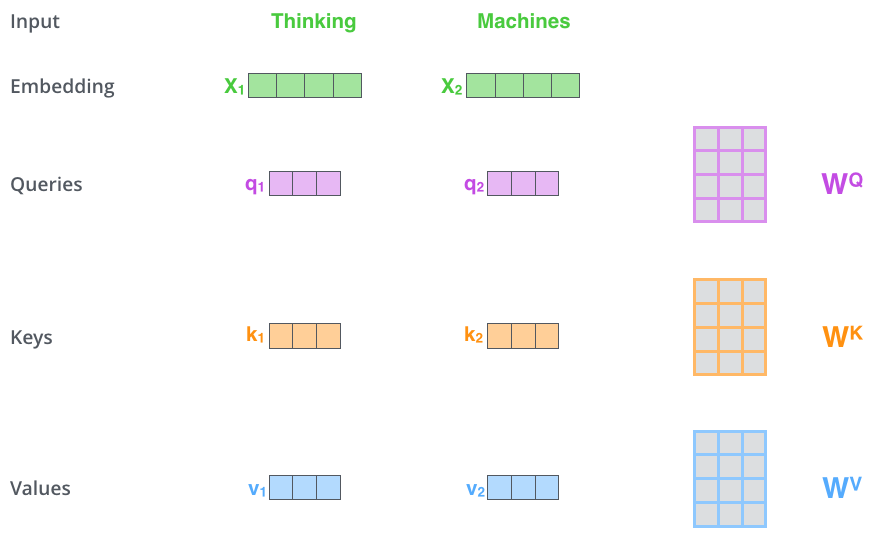

Transformer输入的实例是由一系列token组成的句子，所以自注意力指的就是句子内部。**首先$Q$向量与$K$向量相乘，获得一个相似度数值，这一数值除以$\sqrt{d_k}$（这样梯度会更稳定），再使用softmax对所有值的乘积做指数归一化，归一化后的结果一般被称为注意力矩阵。接着将句子中其他token的$V$与对应的attention分值相乘，之后对加权后的向量求和，就获得了token的新表示，即下图中的$Z$。**


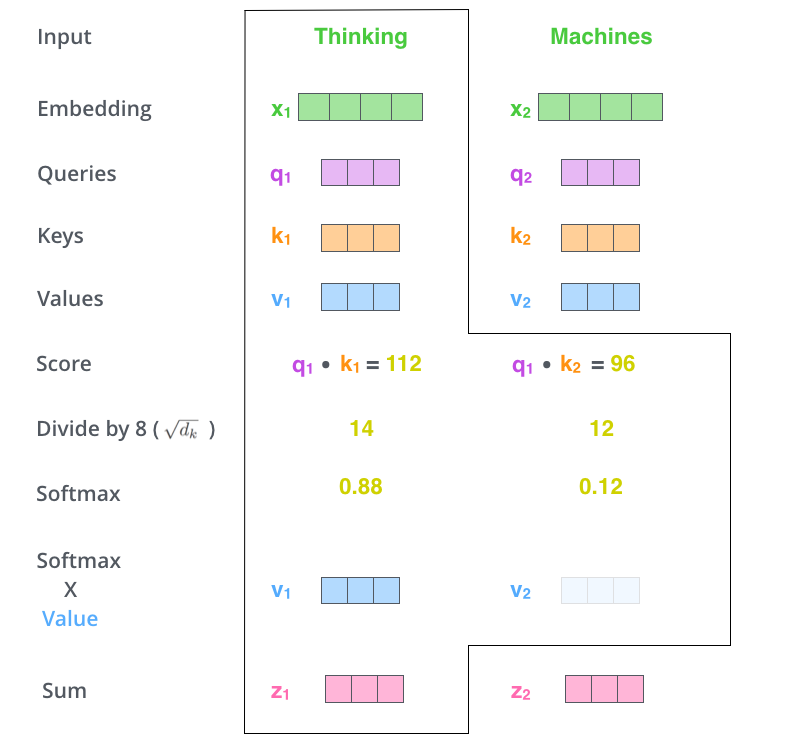

在自注意力机制中，query、key、value 是通过对输入序列进行线性变换得到的。这些线性变换是通过权重矩阵（学习的参数）和输入序列相乘得到的。
- 线性映射层
    - self.linear_query = nn.Linear(d_model, d_model)
    - self.linear_key = nn.Linear(d_model, d_model)
    - self.linear_value = nn.Linear(d_model, d_model)
- 线性映射
    - query = self.linear_query(x)
    - key = self.linear_key(x)
    - value = self.linear_value(x)

### 自注意力层的矩阵计算


在实际应用中，一个句子中的所有向量会合并为一个输入矩阵并行操作，如下图所示，看起来复杂无比的多头变换，简化为了一个矩阵变换。

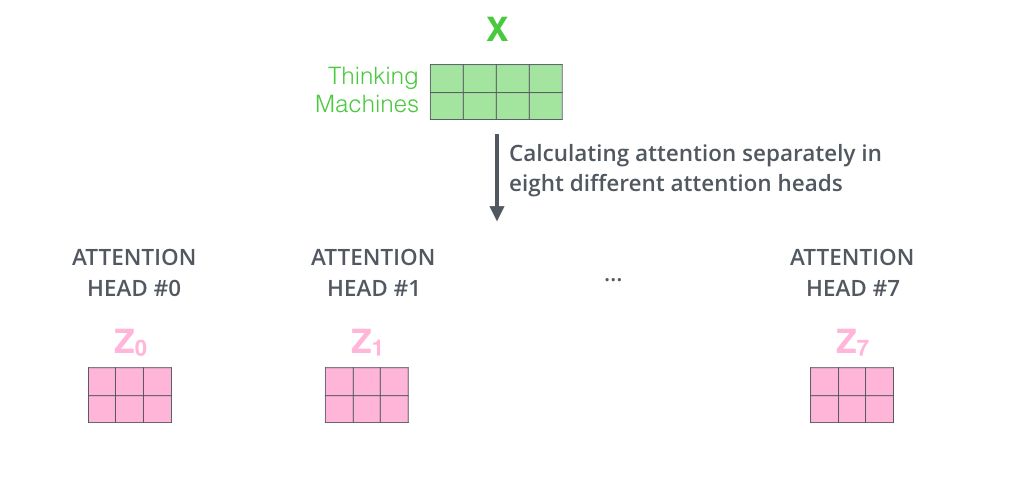

随后的注意力计算如下图所示，分别将每个头的输入乘以矩阵$W^Q$、$W^K$、$W^V$，同时生成句子中所有token的$Q$、$K$、$V$。对生成的$Q$与$K$进行矩阵乘法运算，再通过softmax层进行归一化，利用矩阵计算并行加速计算过程。


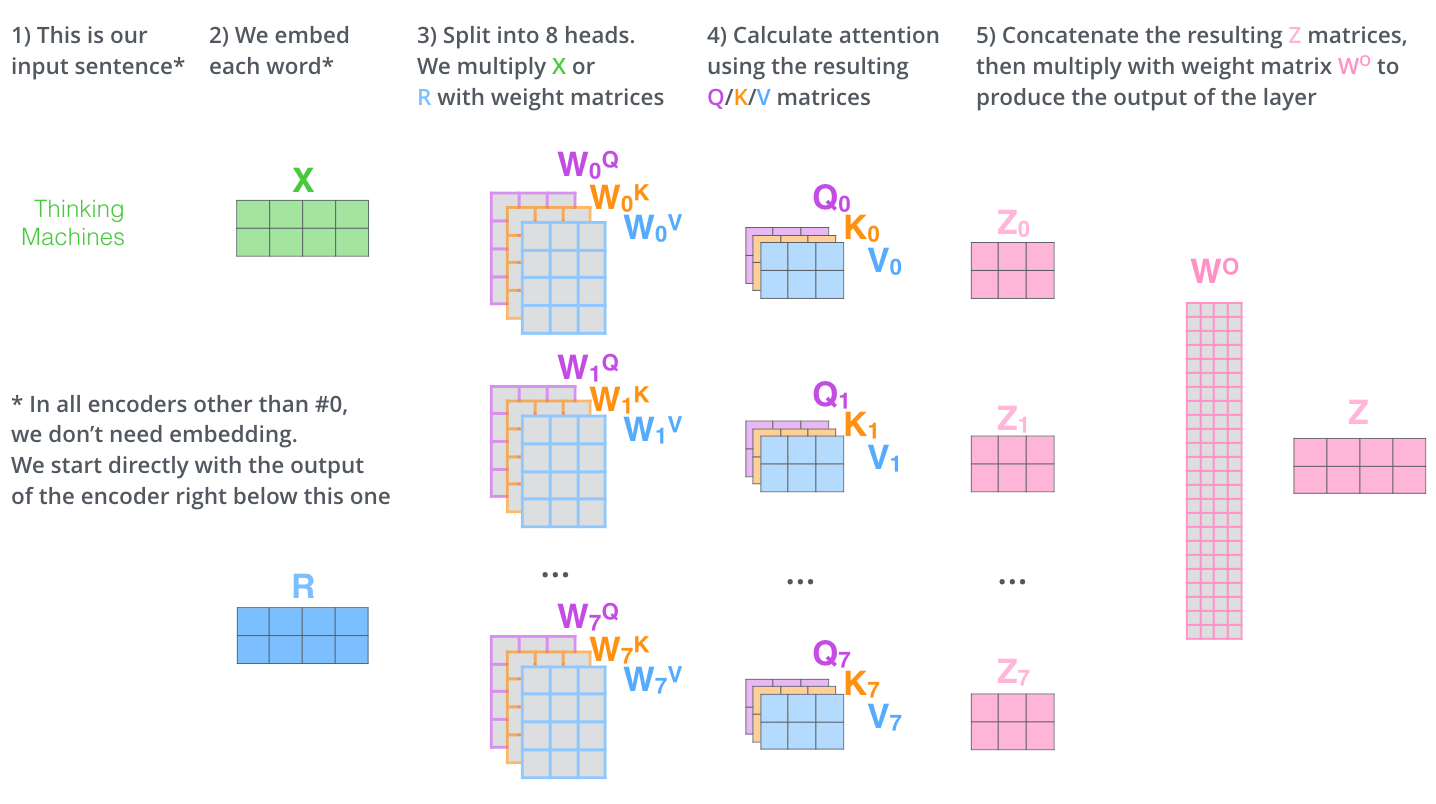

自注意力层的处理流程用公式总结如下：
$$attention(Q,K,V)=softmax(\frac{(QK^T)}{\sqrt{d_k}})V$$

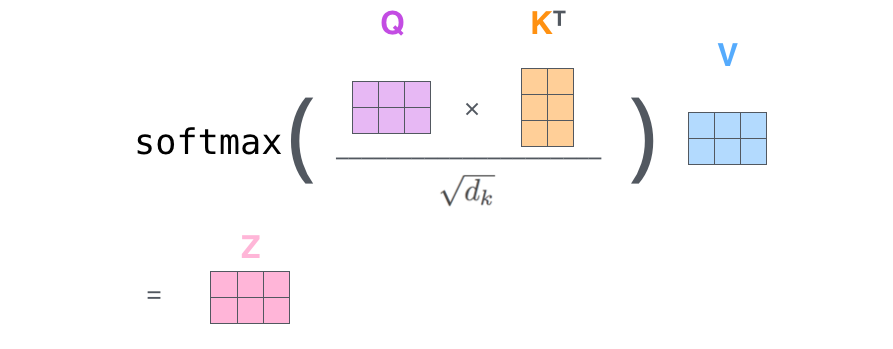

### 掩码机制详解

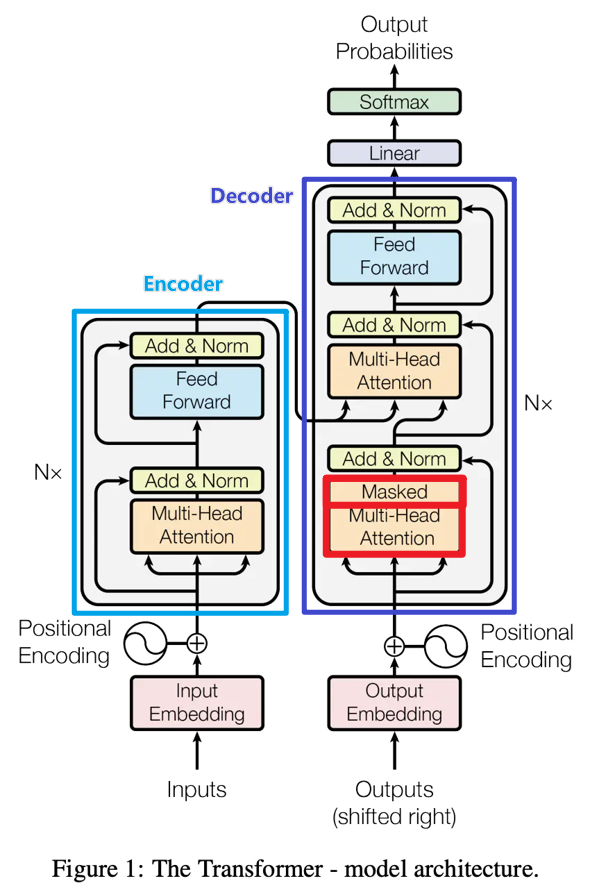

Mask机制经常被用于NLP任务中，按照作用总体来说可以分成两类：

- 用于处理非定长序列的padding mask；
- 用于防止标签泄露的sequence mask。

Transformer中同时用到了这两种Mask机制。

#### padding mask

在NLP任务中，文本通常是不定长的，所以在输入一个样本长短不一的batch到网络前，要对batch中的样本进行truncating截断/padding补齐操作，以便能形成一个张量的形式输入网络，对于一个batch中过长的样本，进行截断操作，而对于一个长度不足的样本，往往采用特殊字符"\<PAD>"进行padding（也可以是其他特殊字符，但是pad的字符要统一）。Mask矩阵中可以用1表示有效字，0代表无效字（也可以True/False）。

**Q和K在点积之后，需要先经过mask再进行softmax，因此，对于要屏蔽的部分，mask之后的输出需要为负无穷，这样softmax之后输出才为0。**

#### sequence mask

sequence mask有各种各样的形式和设计，最常见的应用场景是在需要一个词预测下一个词的时候，如果用self attention 或者是其他同时使用上下文信息的机制，会导致模型”提前看到“待预测的内容，这显然不行，所以为了不泄露要预测的标签信息，就需要 mask 来“遮盖”它。如下图所示，这也是Transformer中Decoder的Masked Multi-Head self-attention使用的Mask机制。

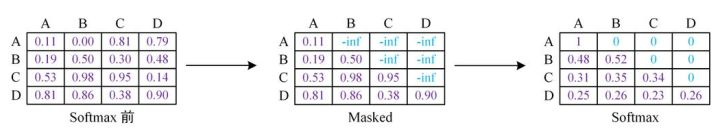

### 残差连接与层归一化
 

在大型网络的训练中，梯度消失与梯度不稳定始终是阻碍模型收敛的重要问题。残差连接创造了一条梯度回传的“捷径”，大大缓解了梯度消失问题，加速了模型收敛。在自然语言处理领域，一般会使用层归一化来解决梯度不稳定的问题。Transformer中也引入了这两种机制来稳定模型的训练，如下图所示。


![hello](../images/p37.png)

**通过自注意力层之后，网络需要对输出的向量做两个简单的操作。**
- 将自注意力层的输出与输入相加，这条路径通常被称为残差连接，这使得大型神经网络更容易训练，同时也能提升网络的表现。
- 层归一化通过两个可学习的参数对输入进行规范化，让输入分布更加稳定，使模型的训练过程更加平稳。

后续的一些研究发现，层归一化放置在不同位置，采用不同的结构，进行不一样的初始化，对训练大型网络有重要的影响。


### 逐点计算的前向网络层


奇幻巧妙的自注意力层后，跟着一个平平无奇的胖子层FFN——前向网络层。前向网络层普遍应用在各类神经网络中，出现在Transformer中既不惊艳，也不意外。但各种文献中的实验都证明，删除Transformer中的前向网络层将严重影响模型在任务上的表现，而增加前向网络层的参数能明显提升模型的性能。

**对于自注意力层的输出，前向网络层会做两次矩阵变换。这里同样存在残差连接和层归一化。前向网络层的输出与输入相加，然后经过层归一化，接着传递给下一个注意力模块。每一个前向网络层计算针对一个token，逐点(point-wise)计算中的点指的就是token。**

Transformer中的前向网络层中的两个矩阵变换如下图所示，其中第一个变换将矩阵的维度变大，第二个变换将矩阵的维度还原。一系列研究表明，第一次变换的维度越大，模型最终的表现越好。arXiv上的一篇论文提出一种猜想，前向网络层的作用类似于记忆层，所以这个看起来平平无奇的层对整个模型的贡献也是不可忽略的。


![hello](../images/p38.png)

### 解码器中的自注意力


解码器既需要理解目标语言的句子，也需要了解源语言的句子，所以解码器block中存在两个注意力层：自注意力层和编码—解码注意力层。

编码器中，一个句子的所有token同时输入，所以每个词都可以“看到”其他词。在解码器中，所有的词也同时输入，但由于解码器使用语言模型的建模方式，所以要求每个词只能“看到”前面的词。

解码器的自注意力层结构与编码器的自注意力层结构一致。

解码器的编码—解码注意力层结构与自注意力层也一致，存在query、key和value三个向量。**为了更好地建立源语言句子与目标语言句子之间的联系，query来自前一层的解码器，key和value来自编码器的输出。**

![hello](../images/p39.png)

### 解码器的输出层


解码器的尽头是输出层，由一个线性层和一个softmax层组成。线性层将解码器的输出映射到词表大小的维度，softmax将变换后的向量归一化。

解码器的最后一层输出的是一个大小固定（通常为1024或者512）的向量，借助输出层，就可以将这个向量转换为一个词表的分布。观察词表的分布，我们就可以知道这个位置最合适输出的单词是什么。


## 多输入多输出多步预测

在 Transformer 模型中，**输入张量的形状通常是(sequence_length, batch_size, input_dim)。**这是因为 Transformer 模型中的自注意力机制（self-attention mechanism）和位置编码（position encoding）的设计。

### 数据准备

In [3]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [4]:
data_path = "../data/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [5]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [6]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [7]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/Transformer'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [8]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[r_begin: r_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[r_begin: r_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)

    return X, y, X_stamp, y_stamp, data_loader

In [9]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 1,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18404, 6, 2]),y_size: torch.Size([18404, 4, 2]),loader_len: 576
X_size: torch.Size([2623, 6, 2]),y_size: torch.Size([2623, 4, 2]),loader_len: 82
X_size: torch.Size([5253, 6, 2]),y_size: torch.Size([5253, 4, 2]),loader_len: 165


### 模型定义

In [10]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()
        
        # freq拆分
        number = re.findall('[0-9]', freq)
        number = 1 if len(number)==0 else int(''.join(number))
        string = re.findall('[a-z]', freq)[0]
        if string == 'h':
            hour_size = int(24 / number)
        elif string == 't':
            hour_size = 24
            minute_size = int(60 / number)
        elif string == 's':
            hour_size = 24
            minute_size = 60
            second_size = int(60 / number)
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        if freq == 's':
            self.second_embed = Embed(second_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        second_x = self.second_embed(x[:, :, 5]) if hasattr(
            self, 'second_embed') else 0.
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x + second_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
    
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x
    
    
# 自编码类
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# Transformer模型
class Transformer(nn.Module):
    """
        embed: time features encoding, options:[timeF, fixed, learned]
        freq: 'freq for time features encoding, options:[s:secondly, 
            t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], 
            you can also use more detailed freq like 15min or 3h'
    """
    def __init__(self, seq_len, pred_len, label_len, output_attention, enc_in, d_model, dropout, factor, n_heads, d_ff, 
                e_layers, dec_in, d_layers, c_out, embed, freq):
        super(Transformer, self).__init__()
        self.pred_len = pred_len
        self.output_attention = output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [11]:
def train(train_args, model_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    figure_path = train_args['figure_path'] # 损失函数图保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len']  # 预测长度
    label_len = model_args['label_len'] # 先验长度

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            with open(path + '/' + 'checkpoint.pth', 'wb') as f:
                torch.save(model.state_dict(), f)
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                outputs = outputs[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:]
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    def plot_loss(train_loss, val_loss):
        """
        绘制训练和验证损失曲线

        参数:
        - train_loss: 训练损失数组
        - val_loss: 验证损失数组
        """
        # 设置全局字体和分辨率
        rcParams['font.family'] ='serif'
        rcParams['font.serif'] = ['Times New Roman']
        # rcParams['figure.dpi'] = 300

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white", font='serif')

        # 自动生成 epochs（假设train_loss和val_loss长度一致）
        epochs = np.arange(len(train_loss))

        # 创建图形并优化细节
        plt.figure(figsize=(10, 6))

        # 绘制训练和验证曲线
        plt.plot(epochs, train_loss, label='Training', color='#d62728',
                linewidth=1.5, marker='', markersize=4, alpha=0.8)
        plt.plot(epochs, val_loss, label='Validation', color='#1f77b4',
                linewidth=1.5, marker='', markersize=4, alpha=0.8)

        # 添加标题和标签
        plt.title('Training and Validation Loss', fontsize=20,
                fontweight='bold', color='black')
        plt.xlabel('Epoch', fontsize=16)
        plt.ylabel('Loss', fontsize=16)

        # 旋转 x 轴标签
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)

        # 添加图例
        legend = plt.legend(fontsize=14, loc='upper right', frameon=False)
        for text in legend.get_texts():
            text.set_color('black')

        # 启用横向网格线，调整颜色和透明度
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5,
                alpha=0.5, color='lightgray')

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 修改左侧和底部边框的样式，调整颜色和透明度
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')

        ax.tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 保存图像
        plt.savefig(figure_path + '/loss', dpi=600, bbox_inches='tight')

        # 展示图形
        plt.show()

    if plots:
        plot_loss(train_losses, val_losses)

    return model

  2%|█▋                                                                                 | 1/50 [00:14<11:52, 14.53s/it]

Epoch [1/50], Training Loss: 0.1384, Validation Loss: 0.0047
Validation loss decreased (inf --> 0.004660).  Saving model ...
Updating learning rate to 0.0009990133642141358


  4%|███▎                                                                               | 2/50 [00:27<10:44, 13.43s/it]

Epoch [2/50], Training Loss: 0.0052, Validation Loss: 0.0020
Validation loss decreased (0.004660 --> 0.001997).  Saving model ...
Updating learning rate to 0.000996057350657239


  4%|███▎                                                                               | 2/50 [00:38<15:16, 19.10s/it]

Epoch [3/50], Training Loss: 0.0033, Validation Loss: 0.0031
EarlyStopping counter: 1 out of 1
Early stopping!


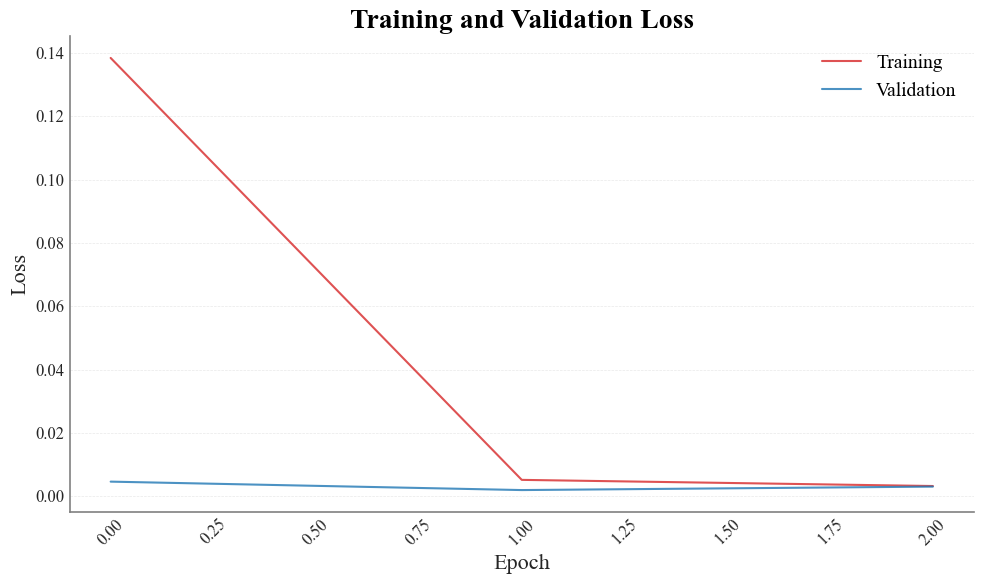

In [12]:
# 构造参数字典
params3 = {
    "train_args": {
        "features": 'M',
        "model_name": Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 1,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/Transformer",
        "figure_path": "../outputs/results/Transformer",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3, 
        'label_len': 1,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
model = train(**params3)

### 模型测试

In [19]:
def test(test_args):
    # 参数配置
    features = test_args['features']
    times = test_args['times']
    model = test_args['model']
    x_test = test_args['x_test']
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test']
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len']
    label_len = test_args['label_len']
    scaler_path = test_args['scaler_path']
    device = test_args['device']  # 可选'cuda'和'cpu'
    test_path = test_args['test_path']  # 结果保存路径
    drawing_point = test_args['drawing_point'] # 绘制第几个预测点，从0开始

    # 检查可用device
    device = torch.device(device)

     # 读取归一化参数
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")
    
    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 *
                        (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 决定系数
        def R2(pred, true):
            ss_res = np.sum((true - pred) ** 2)
            ss_tot = np.sum((true - np.mean(true)) ** 2)
            return 1 - (ss_res / ss_tot)
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        r2 = R2(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}\nr2: {:.4f}".format(
            mae, mse, rmse, mape, mspe, r2))
        return mae, mse, rmse, mape, mspe, r2

    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # 关闭自动求导功能
    model.eval()  # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, :label_len, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        f_dim = -1 if features == 'MS' else 0
        y_pred = outputs[:, -pred_len:, f_dim:]
        y_test = y_test[:, -pred_len:, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        # y_pred = y_scaler.inverse_transform(y_pred[:, -1, :]) # 选取最后一个预测数据
        # y_true = y_scaler.inverse_transform(y_true[:, -1, :])
        mae, mse, rmse, mape, mspe, r2 = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy',
                np.array([mae, mse, rmse, mape, mspe, r2]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)

    # 结果分析
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        """
        绘制真实值和预测值的时间序列曲线

        参数:
        - timeseries_x: 真实值的时间序列 x 轴数据
        - timeseries_y: 真实值的时间序列 y 轴数据
        - test_plot_x: 预测值的时间序列 x 轴数据
        - test_plot_y: 预测值的时间序列 y 轴数据
        - figure_path: 图像保存路径
        """
        # 设置全局字体和分辨率
        rcParams['font.family'] ='serif'
        rcParams['font.serif'] = ['Times New Roman']
        # rcParams['figure.dpi'] = 300

        # 使用 Seaborn 设置白色背景样式
        sns.set(style="white", font='serif')

        # 创建图形并优化细节
        plt.figure(figsize=(8, 5))

        # 绘制真实值曲线
        plt.plot(timeseries_x, timeseries_y, label='GroundTruth', color='#d62728', linewidth=1.5, marker='', alpha=0.8)
        # 绘制预测值曲线
        plt.plot(test_plot_x, test_plot_y, label='Predictions', color='#1f77b4', linewidth=1.5, marker='', alpha=0.8)

        # # 添加垂直线条示例（可根据需要调整位置）
        # plt.axvline(x=len(timeseries_x) // 2, color='r', linestyle='--', alpha=0.5)

        # 添加标题和标签
        plt.title('True vs Predicted', fontsize=18, fontweight='bold', color='black')
        plt.xlabel('Time Steps', fontsize=14)
        plt.ylabel('Values', fontsize=14)

        # 旋转 x 轴标签
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)

        # 添加图例
        legend = plt.legend(fontsize=12, loc='upper right', frameon=False)
        for text in legend.get_texts():
            text.set_color('black')

        # 启用横向网格线，调整颜色和透明度
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5, color='lightgray')

        # 去掉顶部和右侧的边框，仅显示左侧和底部的边框
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 修改左侧和底部边框的样式，调整颜色和透明度
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')

        ax.tick_params(axis='both', which='both', length=0)

        # 调整布局以防止标签重叠
        plt.tight_layout()

        # 保存图像
        plt.savefig(figure_path + '/test', dpi=600, bbox_inches='tight')

        # 展示图形
        plt.show()

    # 绘制测试曲线
    if drawing_point != -100:
        # y_pred = y_pred[:, drawing_point].reshape(-1, )[-300:]
        # y_true = y_true[:, drawing_point].reshape(-1, )[-300:]
        y_pred = y_pred[:, -1, drawing_point].reshape(-1, )[-300:] # 选取最后一个预测数据
        y_true = y_true[:, -1, drawing_point].reshape(-1, )[-300:]
        x = times[-len(y_true):][-300:]
        static_part_timeseries(x, y_true, x, y_pred, test_path)
        
    return mse

mae: 0.0476
mse: 0.0032
rmse: 0.0562
mape: 0.1025
mspe: 0.0178
r2: 0.9189


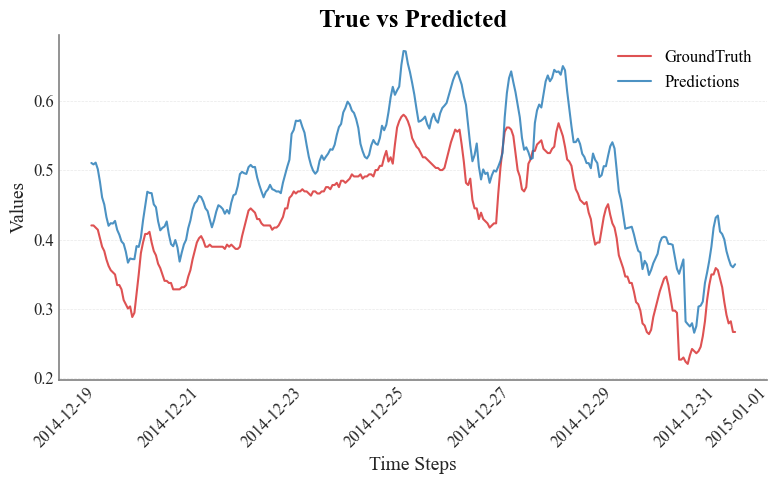

In [20]:
# 构造参数字典
params4 = {
    "test_args": {
        "features": 'M',
        "times": ts_data.index,
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'drawing_point': -1,
        'label_len': 1,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/Transformer',
        "scaler_path": '../outputs/scalers/Transformer',
    }
}
res = test(**params4)

### 模型预测

In [21]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target']
    features = task_args['features']
    mode = task_args['mode'] # 可选'online'和'offline'
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name']
    x_true = predict_args['x_true']
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    pred_len = model_args['pred_len']
    label_len = model_args['label_len']
    seq_len = model_args['seq_len']

    # 检查可用device
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 预测模式
    if mode == 'online':
        # 生成固定长度的时间范围
        x_true = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        x_true = x_true[columns]
        timedelta = x_true.index[-1] - x_true.index[-2]  # 时间差
        if label_len != 0:
            y_stamp = pd.date_range(start=x_true.index[-label_len],
                                    end=x_true.index[-label_len] +
                                    timedelta*(label_len+pred_len-1),
                                    freq=freq)
        else:
            y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1),
                                    end=x_true.index[-1] +
                                    timedelta*(label_len+pred_len),
                                    freq=freq)
        x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq)  # x时间戳数据
        x_stamp = x_stamp.transpose(1, 0)
        y_time = y_stamp
        y_stamp = time_features(y_stamp, freq=freq)  # y时间戳数据
        y_stamp = y_stamp.transpose(1, 0)
    
        # 转换类型
        x_true[columns] = x_scaler.transform(x_true)  # 归一化
        x_true = x_true.values.astype('float32')
        x_true = torch.as_tensor(x_true).unsqueeze(0).float()  # 转为张量
        x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
        y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
        # 关闭自动求导功能
        model.eval()  # 一定要有
        with torch.no_grad():
            x_true = x_true.to(device)
            x_stamp = x_stamp.to(device)
            y_stamp = y_stamp.to(device)
            # decoder输入
            B, _, _ = x_true.shape
            dec_inp = torch.zeros((B, pred_len + label_len, len(target))).float().to(device) # 占位符
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :])  # 反归一化
    
        # 输出为dataframe
        y_pred = pd.DataFrame(
            data=y_pred, index=y_time[-pred_len:], columns=target)
    # 离线模式
    else:
        # 构造数据集
        x_true_ = loader(data_path=None, data=x_true, time_col=time_col)  # 原始数据
        time_columns = x_true_.index  # 获取时间列
        x_true_ = x_true_.copy()[columns]
    
        # X时间编码
        x_stamp = pd.to_datetime(x_true_.index)
        x_stamp = time_features(x_stamp, freq=freq)
        x_stamp = x_stamp.transpose(1, 0)
    
        # y时间编码，包含未来的时间
        timedelta = x_true_.index[-1] - x_true_.index[-2]  # 时间差
        y_stamp = pd.date_range(start=x_true_.index[0],
                                end=x_true_.index[-1] +
                                timedelta*(pred_len),
                                freq=freq)
        y_stamp = time_features(y_stamp, freq=freq)
        y_stamp = y_stamp.transpose(1, 0)
    
        # X归一化
        x_true_[columns] = x_scaler.transform(x_true_)
        x_true_ = x_true_.values.astype('float32')
    
        # 生成预测张量
        X_true, X_stamp, Y_stamp = [], [], []
        sample_freq = 1
        for index in range(0, len(x_true) - seq_len + 1, sample_freq):
            # 起点
            s_begin = index
            # 终点(起点 + 回视窗口)
            s_end = s_begin + seq_len
            # (终点 - 先验序列窗口)
            r_begin = s_end - label_len
            # (终点 + 预测序列长度)
            r_end = r_begin + label_len + pred_len
    
            # 数据维度
            feat = x_true_[s_begin: s_end]
            X_true.append(np.array(feat))
    
            # 时间维度
            xs = x_stamp[s_begin: s_end]
            ys = y_stamp[r_begin: r_end]
            X_stamp.append(np.array(xs))
            Y_stamp.append(np.array(ys))
        X_true = torch.as_tensor(X_true).float()
        X_stamp = torch.as_tensor(X_stamp).float()
        Y_stamp = torch.as_tensor(Y_stamp).float()
    
        # 模型预测
        model.eval()
        with torch.no_grad():
            X_true = X_true.to(device)
            X_stamp = X_stamp.to(device)
            Y_stamp = Y_stamp.to(device)
    
            # decoder输入
            B, _, _ = X_true.shape
            dec_inp = torch.zeros(
                (B, pred_len + label_len, len(target))).float().to(device)
            y_pred = model(X_true, X_stamp, dec_inp, Y_stamp)
            y_pred = y_pred.cpu().detach().numpy()
            f_dim = -1 if features == 'MS' else 0
            y_pred = y_pred[:, -pred_len:, f_dim:]
    
        # y_pred的形状为 (batch_size, pred_len, feature_dim)
        batch_size, pred_len, feature_dim = y_pred.shape
        time_index = time_columns[seq_len-1:]
    
        # 初始化一个空的 DataFrame，每行是初始时间，每列是递增的预测步
        # 列名格式为 target_i，例如 target_1 表示预测步1，target_2 表示预测步2，依此类推
        columns = [f"{t}_{i+1}" for i in range(pred_len) for t in target]
        result_df = pd.DataFrame(index=time_index, columns=columns)
    
        # 填充 DataFrame，每一行是一个时间点的预测序列
        for i in range(batch_size):
            # 当前时间点的预测
            pred_data = y_scaler.inverse_transform(
                y_pred[i, :, :])  # 形状 (pred_len, feature_dim)
            pred_flattened = pred_data.flatten()  # 将预测结果展平
    
            # 将展平的预测步依次填入当前行
            result_df.iloc[i] = pred_flattened
    
        # 将原始数据与预测数据合并输出
        result_df = result_df.reset_index().rename(columns={'index': time_col})
        select_columns = [time_col] + target
        y_pred = pd.merge(x_true[select_columns], result_df, on=time_col, how='left')

    return y_pred

#### 实时预测

In [23]:
data_path = "../data/energy.csv"
ts_data = pd.read_csv(data_path).iloc[:60, :]
# 构造参数字典
params5 = {
    "task_args": {
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
        "mode": 'online'
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": Transformer,
        "model_path": "../outputs/best_models/Transformer/checkpoint.pth",
        "x_true": ts_data,
        "scaler_path": '../outputs/scalers/Transformer',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
y_pred = predict(**params5)

In [24]:
y_pred

,load,temp
2012-01-03 12:00:00,3007.884521,-1.258537
2012-01-03 13:00:00,3037.790771,-1.275433
2012-01-03 14:00:00,3064.525146,-1.150390


#### 离线预测

In [25]:
data_path = "../data/energy.csv"
ts_data = pd.read_csv(data_path)
ts_data['time'] = pd.to_datetime(ts_data['time'])
# 构造参数字典
params5 = {
    "task_args": {
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
        "mode": 'offline'
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": Transformer,
        "model_path": "../outputs/best_models/Transformer/checkpoint.pth",
        "x_true": ts_data,
        "scaler_path": '../outputs/scalers/Transformer',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 60,
        'pred_len': 3, 
        'label_len': 10,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 2,
        'dec_in': 2,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 2
    },
}
y_pred = predict(**params5)

In [26]:
y_pred

,time,load,temp,load_1,temp_1,load_2,temp_2,load_3,temp_3
0,2012-01-01 00:00:00,2698.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 01:00:00,2558.0,32.67,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 02:00:00,2444.0,30.00,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 03:00:00,2402.0,31.00,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 04:00:00,2403.0,32.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,4012.0,18.00,2985.747559,1.001727,2969.425293,1.117663,2948.479004,1.294665
26300,2014-12-31 20:00:00,3856.0,16.67,2930.102295,1.516325,2907.581299,1.668102,2879.841309,1.865505
26301,2014-12-31 21:00:00,3671.0,17.00,2855.27124,2.110281,2829.161865,2.309696,2781.743164,-1.68133
26302,2014-12-31 22:00:00,3499.0,15.33,2778.30542,2.78472,2767.819824,-1.376075,2771.893799,-1.847129


### 结果分析

In [27]:
# 获取最后一个预测结果
def last_prediction(prediction, pred_len, time_col, target):
    pre_target = [i+'_'+str(pred_len) for i in target]
    prediction_target = prediction[pre_target]
    time = prediction[[time_col]]
    # 向下平移数据
    prediction_shift = prediction_target.shift(pred_len)
    prediction_shift.columns = target
    # 对齐时间
    last_prediction = pd.concat([time, prediction_shift], axis=1)
    
    return last_prediction

In [28]:
# 获取最后一个预测结果
params6 = {
    "prediction": y_pred,
    "pred_len": 3,
    "time_col": 'time',
    "target": ['load', 'temp']
}
y_pred = last_prediction(**params6)

In [29]:
y_pred

,time,load,temp
0,2012-01-01 00:00:00,None,None
1,2012-01-01 01:00:00,None,None
2,2012-01-01 02:00:00,None,None
3,2012-01-01 03:00:00,NaN,NaN
4,2012-01-01 04:00:00,NaN,NaN
...,...,...,...
26299,2014-12-31 19:00:00,3063.435791,-0.535095
26300,2014-12-31 20:00:00,3036.665039,0.140097
26301,2014-12-31 21:00:00,2998.127197,0.722218
26302,2014-12-31 22:00:00,2948.479004,1.294665


#### 评估指标

In [30]:
# 计算评估指标
def score(x1: pd.DataFrame,
          x2: pd.DataFrame,
          time_col: Union[str, None] = None,
          eval_metrics: str = 'rmse') -> float:
    """
    计算评估指标

    参数说明
    ----------
    x1 : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x2 : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    eval_metrics : {str}
        评估指标值，可选'r2'和'rmse'

    返回值
    -------
    eval_value : {float}
        评估值
    """
    # 规范化数据
    x1 = x1.reset_index(drop=True)
    x2 = x2.reset_index(drop=True)

    # 选取时间列
    if time_col != None:
        no_time_cols = [i for i in x1.columns if i != time_col]
        x1[time_col] = pd.to_datetime(x1[time_col])
        x1_no_time = x1.loc[:, no_time_cols].values.astype('float32')
        x2[time_col] = pd.to_datetime(x2[time_col])
        x2_no_time = x2.loc[:, no_time_cols].values.astype('float32')
    else:
        x1_no_time = x1.values.astype('float32')
        x2_no_time = x2.values.astype('float32')

    # 缺失值删除
    x1_not_nan_index = np.where(~np.isnan(x1_no_time))[0]
    x2_not_nan_index = np.where(~np.isnan(x2_no_time))[0]
    not_nan_index = list(set(x1_not_nan_index) & set(x2_not_nan_index))
    x1_not_nan = x1_no_time[not_nan_index]
    x2_not_nan = x2_no_time[not_nan_index]

    # 计算评估指标
    if eval_metrics == 'r2':
        eval_value = r2_score(x1_not_nan, x2_not_nan)
    elif eval_metrics == 'rmse':
        eval_value = np.sqrt(mean_squared_error(x1_not_nan, x2_not_nan))

    return round(eval_value, 3)

In [31]:
# 评估指标
params7 = {
    "x1": ts_data,
    "x2": y_pred,
    "time_col": 'time',
    "eval_metrics": 'rmse'
}
score(**params7)

np.float64(467.076)

#### 结果绘制

In [32]:
# 绘制子图
def __axs_plot(axs: ndarray,
               nums: int,
               x_in: DataFrame,
               x_out: DataFrame,
               time_col: Union[str, None],
               x_time: ndarray,
               y_label: str,
               threshold: float = 0.05):
    """
    绘制子图函数

    参数说明
    ----------
    axs : {numpy.ndarray}
        绘图示例
    nums : {int}
        绘制子图的个数
    x_in : {DataFrame} of shape (n_samples, n_features)
        实际值
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测值
    time_col : {str}
        时间列
    x_time : {numpy.ndarray}
        x轴的值
    y_label : {str}
        y轴标签
    threshold : {float}
        超限阈值比例

    返回值
    -------
    None
    """
    if nums > 1:
        for nn, ax in enumerate(axs):
            true = x_in.iloc[:, nn].values.astype("float")
            predict = x_out.iloc[:, nn].values.astype("float")
            # 选择数据，同一张子图需要绘制实际值和预测值曲线
            ax.plot(x_time, true)
            ax.plot(x_time, predict)
            # 绘制x轴标签
            if nn == nums - 1:
                ax.set_xlabel(time_col, fontsize=14)
            # 绘制y轴标签
            ax.set_ylabel('value', fontsize=14)
            # 绘制预测阈值带（安全范围的区间）
            ax.fill_between(x_time,
                            predict - predict * threshold,
                            predict + predict * threshold,
                            facecolor='red',
                            alpha=0.3)
            # 绘制图例
            rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
            ax.legend([
                y_label[nn] + " 原始值", y_label[nn] + " 预测值" +
                " rmse: " + str(rmse),
                y_label[nn] + " 预警区间"
            ])
            # x轴文字旋转方向
            for xtick in ax.get_xticklabels():
                xtick.set_rotation(45)
    else:
        # 选择数据，同一张子图需要绘制实际值和预测值曲线
        if type(y_label) == list:
            y_label = y_label[0]
        true = x_in[y_label].values.astype("float").reshape((-1, ))
        predict = x_out[y_label].values.astype("float").reshape((-1, ))
        axs.plot(x_time, true)
        axs.plot(x_time, predict)
        # 绘制x轴标签
        axs.set_xlabel(time_col, fontsize=14)
        # 绘制y轴标签
        axs.set_ylabel('value', fontsize=14)
        # 绘制预测阈值带（安全范围的区间）
        axs.fill_between(x_time,
                         predict - predict * threshold,
                         predict + predict * threshold,
                         facecolor='red',
                         alpha=0.3)
        # 绘制图例
        rmse = round(score(pd.DataFrame(true), pd.DataFrame(predict)), 3)
        axs.legend([
            y_label + " 原始值", y_label + " 预测值" +
            " rmse: " + str(rmse),
            y_label + " 预警区间"
        ])
        # x轴文字旋转方向
        for xtick in axs.get_xticklabels():
            xtick.set_rotation(45)

    return 0


# 绘制曲线
def plot(x_in: DataFrame,
         x_out: DataFrame,
         time_col: Union[str, None] = None,
         plot_cols: Union[List[str], None] = None,
         threshold: float = 0.05) -> None:
    """
    绘制实际值和预测值曲线

    参数说明
    ----------
    x_in : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    plot_cols : {Union[List[str], None]}
        需要绘制的特征列，如果为None，默认不绘制
    threshold : {float}
        预警阈值比例

    返回值
    -------
    None
    """
    # 选择数据
    if plot_cols == None:
        raise ValueError('请选择需要绘制的点，不能为空！')
    no_time_cols = [i for i in plot_cols if i != time_col]
    x_in[time_col] = pd.to_datetime(x_in[time_col])
    x_time = x_in[time_col]
    x_in = x_in[no_time_cols]
    x_out = x_out[no_time_cols]

    # 子图个数
    axs_nums = len(no_time_cols)

    # 分成左右两块画布
    if axs_nums > 1 and axs_nums % 2 == 0:
        # 左右子图个数
        axsLeft_nums = axsRight_nums = int(axs_nums / 2)
        # 创建画布，支持左右布局
        fig = plt.figure(constrained_layout=True,
                         figsize=(20, 4 * axsLeft_nums))
        subfigs = fig.subfigures(1, 2, wspace=0.07)
        # 左子图
        axsLeft = subfigs[0].subplots(axsLeft_nums, 1, sharex=True)
        __axs_plot(axsLeft, axsLeft_nums, x_in.iloc[:, :axsLeft_nums],
                   x_out.iloc[:, :axsLeft_nums], time_col, x_time,
                   no_time_cols[:axsLeft_nums], threshold)
        # 右子图
        axsRight = subfigs[1].subplots(axsRight_nums, 1, sharex=True)
        __axs_plot(axsRight, axsRight_nums, x_in.iloc[:, axsRight_nums:],
                   x_out.iloc[:, axsRight_nums:], time_col, x_time,
                   no_time_cols[axsRight_nums:], threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    else:
        # 创建画布，支持单一画布
        if axs_nums == 1:
            no_time_cols = no_time_cols[0]
        fig = plt.figure(constrained_layout=True, figsize=(10, 4 * axs_nums))
        axs = fig.subplots(axs_nums, 1, sharex=True)
        __axs_plot(axs, axs_nums, x_in, x_out, time_col, x_time, no_time_cols,
                   threshold)
        # 绘制表头
        fig.suptitle('预警曲线', fontsize=14)
    plt.show()

    return 0

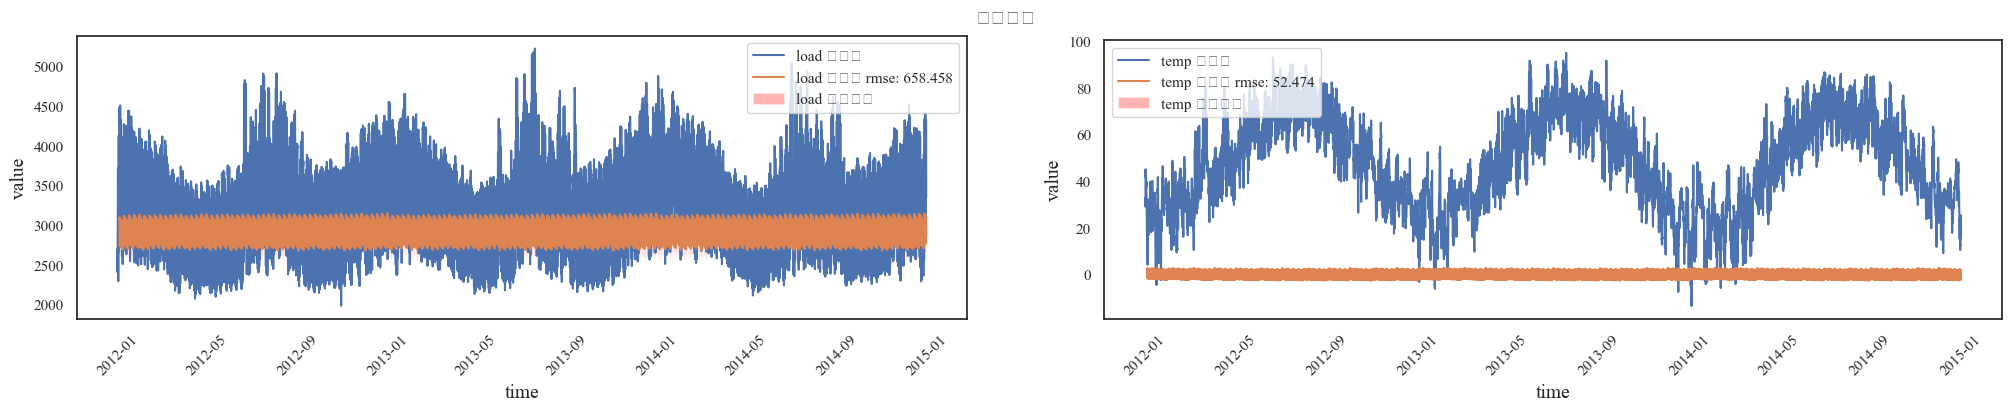

0

In [33]:
param8 = {
    'x_in': ts_data,
    'x_out': y_pred,
    'time_col': 'time',
    'plot_cols': ['load', 'temp'],
    'threshold': 0.05,
}
plot(**param8)

#### 阈值判定

In [34]:
def __warning(data, width_threshold, false_size):
    """
    width_threshold：滑动窗口长度
    false_size：超限次数
    """
    slide = data.rolling(window=width_threshold).sum()
    slide[slide >= false_size] = 1
    slide[slide < false_size] = 0
    slide[slide.isna()] = 0

    return slide


def output(x_in: DataFrame,
           x_out: DataFrame,
           time_col: Union[str, None] = None,
           threshold: float = 0.05,
           is_real_time_warning: bool = False):
    """
    结果合并输出，包含实际值、预测值、预警结果

    参数说明
    ----------
    x_in : {DataFrame} of shape (n_samples, n_features)
        实际数据
    x_out : {DataFrame} of shape (n_samples, n_features)
        预测数据
    time_col : {str}
        时间标签，如果为None，默认数据中不含时间特征
    threshold : {float}
        预警阈值比例
    is_real_time_warning: {bool}
        是否输出预警结果

    返回值
    -------
    x_out : {DataFrame} of shape (n_samples, n_features)
        合并结果数据
    """
    # 规范化列
    x_in = x_in.reset_index(drop=True)
    x_out = x_out.reset_index(drop=True)
    if time_col != None:
        x_time = x_in[[time_col]]
        x_in = x_in.drop(time_col, axis=1)
        x_out = x_out.drop(time_col, axis=1)
    x_cols = x_in.columns  # 实际列
    x_cols_prediction = [i + '_prediction' for i in x_cols]  # 预测列
    x_cols_warning = [i + '_warning_label' for i in x_cols]  # 残差列

    # 阈值规则
    x_high = x_out + x_out * threshold
    x_low = x_out - x_out * threshold
    # print(x_in.columns)

    # 预警判定
    x_warning = pd.DataFrame(data=np.zeros(x_in.shape), columns=x_cols_warning)
    for i in range(x_high.shape[0]):
        for j in range(x_high.shape[1]):
            value = 1 if (x_in.iloc[i, j] > x_high.iloc[i, j]) or (
                x_in.iloc[i, j] < x_low.iloc[i, j]) else 0
            x_warning.iloc[i, j] = value
    if not is_real_time_warning:
        x_warning = __warning(x_warning, 10, 8)
    x_prediction = pd.DataFrame(data=x_out.loc[:, x_cols].values,
                                columns=x_cols_prediction)
    
    # 合并输出
    if time_col != None:
        x_out = pd.concat([x_time, x_in, x_prediction, x_warning], axis=1)
    else:
        x_out = pd.concat([x_in, x_prediction, x_warning], axis=1)
    print('合并输出为：{0}'.format(x_out))

    return x_out

In [35]:
# 合并输出
param9 = {
    'x_in': ts_data,
    'x_out': y_pred,
    'time_col': 'time',
    'threshold': 0.05,
    'is_real_time_warning': True,
}
x_out = output(**param9)

合并输出为：                     time    load   temp load_prediction temp_prediction  \
0     2012-01-01 00:00:00  2698.0  32.00            None            None   
1     2012-01-01 01:00:00  2558.0  32.67            None            None   
2     2012-01-01 02:00:00  2444.0  30.00            None            None   
3     2012-01-01 03:00:00  2402.0  31.00             NaN             NaN   
4     2012-01-01 04:00:00  2403.0  32.00             NaN             NaN   
...                   ...     ...    ...             ...             ...   
26299 2014-12-31 19:00:00  4012.0  18.00     3063.435791       -0.535095   
26300 2014-12-31 20:00:00  3856.0  16.67     3036.665039        0.140097   
26301 2014-12-31 21:00:00  3671.0  17.00     2998.127197        0.722218   
26302 2014-12-31 22:00:00  3499.0  15.33     2948.479004        1.294665   
26303 2014-12-31 23:00:00  3345.0  15.33     2879.841309        1.865505   

       load_warning_label  temp_warning_label  
0                     0.0        